- Data: clean dataset where missing data was replaced with 'missing'. No imputing.
- Approach: 
    - encode text features using TfidfVectorizer.
    - encode brand and categories using OHE
- Models:
    - Ridge Regressor
    - LightGBM
    - SGD
    - Stacking Regressor (ensemble)
- Evaluation metrics:
    - RMSLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import swifter

from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, OrdinalEncoder, StandardScaler
from scipy.sparse import hstack
from IPython.display import Markdown

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style

#### Utils

In [3]:
def get_pred_price(log_price):
    return np.exp(log_price)-1

def normalize_text(text):
    '''
    Handles diacritic marks, superscripts and subscripts.
    Returns the text in lowercase.
    '''
    text = text.replace('–', '-').strip()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8").lower()
    return text

def pre_process_brand(text):
    clean_text = normalize_text(text).replace(' ', '_')
    #clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text)
    return clean_text

def pre_process_category(text):
    clean_text = normalize_text(text)
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text).replace(' ', '_')
    return clean_text

def pred_vs_actual(pred, actual):
    fig, ax = plt.subplots(figsize=(10,6), gridspec_kw={'hspace': 0.3})
    x = range(len(actual))

    ax.plot(x, actual, label='Actual values')
    ax.plot(x, pred, label='Predicted values')
    ax.legend(loc=1, bbox_to_anchor=(0.75, 0, 0.5, 1))
    plt.show()

___

In [4]:
data_path = 'data/'
data_file_name = 'mercari_eda_cleaned.csv'
data_full_path = data_path + data_file_name

product_listings_mercari = pd.read_csv(data_full_path, keep_default_na=False)
display(product_listings_mercari.shape)
product_listings_mercari.head()

(1481661, 12)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers & tablets,components & parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home decor,home decor accents,leather horse statues,new tags leather horses retail stand foot high...
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity


In [5]:
product_listings_mercari['brand_name'] = product_listings_mercari['brand_name'].apply(pre_process_brand)
product_listings_mercari['main_cat'] = product_listings_mercari['main_cat'].apply(pre_process_category)
product_listings_mercari['sub_cat1'] = product_listings_mercari['sub_cat1'].apply(pre_process_category)
product_listings_mercari['sub_cat2'] = product_listings_mercari['sub_cat2'].apply(pre_process_category)

# combining name, item_description, and brand in a single column ('text')
product_listings_mercari.replace('missing', '', inplace=True)
product_listings_mercari['text'] = product_listings_mercari['preprocessed_name'] + ' ' + product_listings_mercari['preprocessed_description'] + ' ' + product_listings_mercari['brand_name']

product_listings_mercari['log_price'] = np.log1p(product_listings_mercari['price'].values.astype(np.float32))

In [6]:
product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description,text,log_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,,10.0,1,No description yet,men,tops,t_shirts,mlb cincinnati reds shirt size xl,description yet,mlb cincinnati reds shirt size xl description ...,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers_tablets,components_parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...,razer blackwidow chroma keyboard keyboard grea...,3.970292
2,2,AVA-VIV Blouse,1,target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops_blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...,ava viv blouse adorable top hint lace key hole...,2.397895
3,3,Leather Horse Statues,1,,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home_decor,home_decor_accents,leather horse statues,new tags leather horses retail stand foot high...,leather horse statues new tags leather horses ...,3.583519
4,4,24K GOLD plated rose,1,,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity,24k gold plated rose complete certificate auth...,3.806663


#### Splitting data

In [7]:
features = ['text','item_condition_id', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2']
X, y = product_listings_mercari[features], product_listings_mercari['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1185328, 6), (296333, 6))

In [8]:
X_train.head()

,text,item_condition_id,shipping,main_cat,sub_cat1,sub_cat2
1142652,brand new skull candy headphones never used,2,0,electronics,tv_audio_surveillance,headphones
1142448,lularoe bow leggings new blue purple os brand ...,2,0,women,athletic_apparel,pants_tights_leggings
220982,sarah deaden teen love books free shipping neg...,2,1,vintage_collectibles,antique,book
479456,authentic harry potter hermione wand hermione ...,1,1,vintage_collectibles,collectibles,souvenir
1299063,victoria secret 34a victoria secret aerie bra ...,3,0,women,underwear,bras


In [9]:
# ohe for category-related features

# main cat
ohe_mcat = OneHotEncoder(handle_unknown="ignore")
ohe_mcat.fit(product_listings_mercari.main_cat.values.reshape(-1,1))

tr_mcat_ohe = ohe_mcat.transform(X_train.main_cat.values.reshape(-1,1))
val_mcat_ohe = ohe_mcat.transform(X_test.main_cat.values.reshape(-1,1))

# sub cat1
ohe_scat1 = OneHotEncoder(handle_unknown="ignore")
ohe_scat1.fit(product_listings_mercari.sub_cat1.values.reshape(-1,1))

tr_scat1_ohe = ohe_scat1.transform(X_train.sub_cat1.values.reshape(-1,1))
val_scat1_ohe = ohe_scat1.transform(X_test.sub_cat1.values.reshape(-1,1))

# sub cat2
ohe_scat2 = OneHotEncoder(handle_unknown="ignore")
ohe_scat2.fit(product_listings_mercari.sub_cat2.values.reshape(-1,1))

tr_scat2_ohe = ohe_scat2.transform(X_train.sub_cat2.values.reshape(-1,1))
val_scat2_ohe = ohe_scat2.transform(X_test.sub_cat2.values.reshape(-1,1))

tr_mcat_ohe.shape, val_mcat_ohe.shape, tr_scat1_ohe.shape, val_scat1_ohe.shape, tr_scat2_ohe.shape, val_scat2_ohe.shape

((1185328, 11),
 (296333, 11),
 (1185328, 113),
 (296333, 113),
 (1185328, 870),
 (296333, 870))

In [10]:
# ohe for shipping and item_condition

# item condition
ohe_cond = OneHotEncoder(handle_unknown="ignore")
ohe_cond.fit(product_listings_mercari.item_condition_id.values.reshape(-1,1))

tr_cond_ohe = ohe_cond.transform(X_train.item_condition_id.values.reshape(-1,1))
val_cond_ohe = ohe_cond.transform(X_test.item_condition_id.values.reshape(-1,1))

# shipping
ohe_ship = OneHotEncoder(handle_unknown="ignore")
ohe_ship.fit(product_listings_mercari.shipping.values.reshape(-1,1))

tr_ship_ohe = ohe_ship.transform(X_train.shipping.values.reshape(-1,1))
val_ship_ohe = ohe_ship.transform(X_test.shipping.values.reshape(-1,1))

tr_cond_ohe.shape, val_cond_ohe.shape, tr_ship_ohe.shape, val_ship_ohe.shape

((1185328, 5), (296333, 5), (1185328, 2), (296333, 2))

In [11]:
# vectorizing name
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
tfidf.fit(X_train.text)

tr_vec_text = tfidf.transform(X_train.text)
val_vec_text = tfidf.transform(X_test.text)

tr_vec_text.shape, val_vec_text.shape

((1185328, 50000), (296333, 50000))

<u>Stacking all features</u>

In [12]:
x_train = hstack((tr_vec_text, tr_cond_ohe, tr_ship_ohe, tr_mcat_ohe, tr_scat1_ohe, tr_scat2_ohe))
x_train.shape

(1185328, 51001)

In [13]:
x_val = hstack((val_vec_text, val_cond_ohe, val_ship_ohe, val_mcat_ohe, val_scat1_ohe, val_scat2_ohe))
x_val.shape

(296333, 51001)

#### Ridge

In [27]:
'''Hyper-param tuning'''

ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10]}

grid_cv = GridSearchCV(ridge, param_grid=ridge_params, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True, cv=3)
%time grid_cv.fit(x_train, y_train)

CPU times: user 1min 57s, sys: 42.5 s, total: 2min 40s
Wall time: 1min 21s


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10]}, return_train_score=True,
             scoring='neg_root_mean_squared_error')

In [28]:
print("Best params: -RMSE %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: -RMSE -0.472659 using {'alpha': 1}


#### Execution Time - Training

CPU times: user 1min 54s, sys: 39 s, total: 2min 33s
Wall time: 38.2 s


#### Execution Time - Prediction

CPU times: user 194 ms, sys: 121 ms, total: 315 ms
Wall time: 80.3 ms


#### Model in Test Data

R2: 0.6046
RMSLE: 0.4688


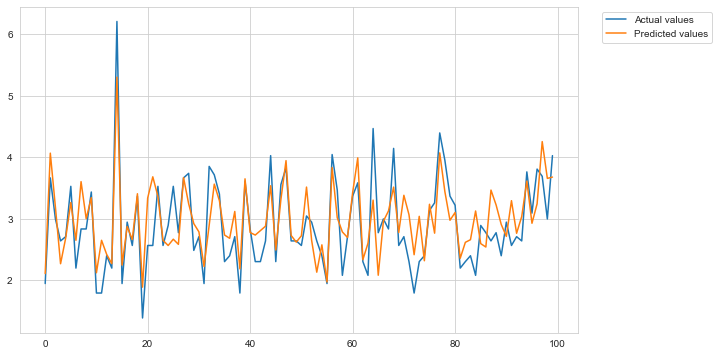

In [29]:
ridge_best = Ridge(alpha=1)
display(Markdown("#### Execution Time - Training"))
%time ridge_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = ridge_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### LightGBM

#### Execution Time - Training

CPU times: user 26min 33s, sys: 34.6 s, total: 27min 8s
Wall time: 4min 11s


#### Execution Time - Prediction

CPU times: user 14.7 s, sys: 190 ms, total: 14.9 s
Wall time: 2.29 s


#### Model in Test Data

R2: 0.6048
RMSLE: 0.4687


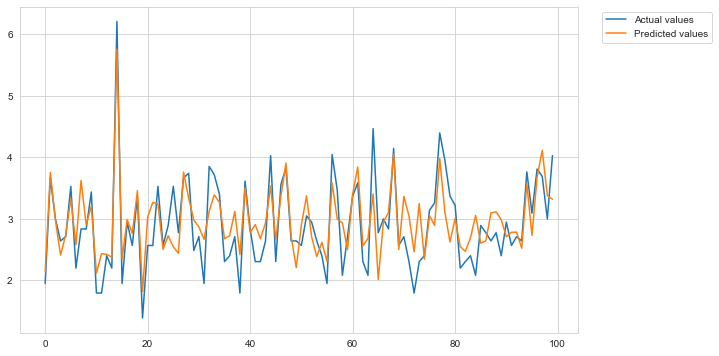

In [34]:
lgb_best = LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=500, reg_alpha=1.5)

display(Markdown("#### Execution Time - Training"))
%time lgb_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lgb_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### SGD

#### Execution Time - Training

CPU times: user 8.35 s, sys: 252 ms, total: 8.6 s
Wall time: 7.93 s


#### Execution Time - Prediction

CPU times: user 653 ms, sys: 209 ms, total: 862 ms
Wall time: 253 ms


#### Model in Test Data

R2: 0.5024
RMSLE: 0.5259


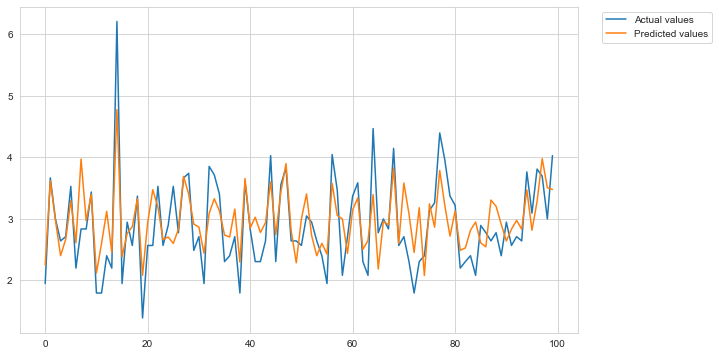

In [37]:
sgd = SGDRegressor(alpha=0.0000001)

display(Markdown("#### Execution Time - Training"))
%time sgd.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = sgd.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

___

#### Stacking Regressor

- https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b

#### Execution Time - Training

CPU times: user 2h 28min 28s, sys: 6min 18s, total: 2h 34min 46s
Wall time: 25min 47s


#### Execution Time - Prediction

CPU times: user 16.8 s, sys: 381 ms, total: 17.2 s
Wall time: 4.25 s


#### Model in Test Data

R2: 0.5436
RMSLE: 0.5036


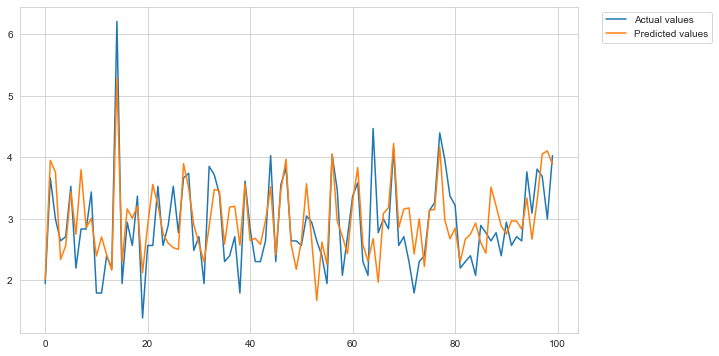

In [39]:
estimators = [('ridge',  Ridge(alpha=1)), 
              ('lgb', LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=500, reg_alpha=1.5))]

reg = StackingRegressor(estimators=estimators, 
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))

display(Markdown("#### Execution Time - Training"))
%time reg.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = reg.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### Execution Time - Training

CPU times: user 2h 32min 38s, sys: 7min 33s, total: 2h 40min 12s
Wall time: 31min 52s


#### Execution Time - Prediction

CPU times: user 15.2 s, sys: 352 ms, total: 15.5 s
Wall time: 2.23 s


#### Model in Test Data

R2: 0.6309
RMSLE: 0.4529


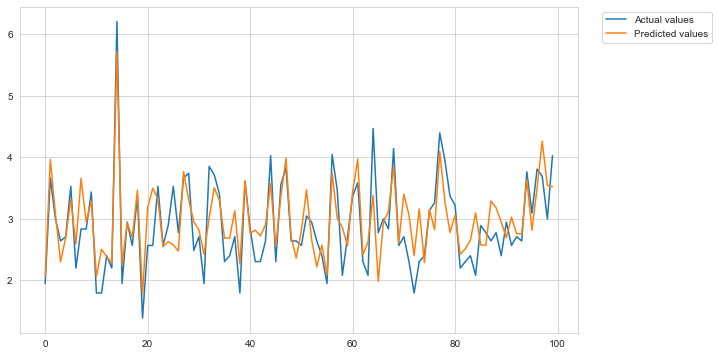

In [40]:
estimators = [('ridge',  Ridge(alpha=1)), 
              ('lgb', LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=500, reg_alpha=1.5))]

reg = StackingRegressor(estimators=estimators) # The default regressor is a RidgeCV.

display(Markdown("#### Execution Time - Training"))
%time reg.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = reg.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

___

Summary:

| **Model**                                | **Notes**                                                                                   | **RMSLE** |
|:-----------------------------------------|:--------------------------------------------------------------------------------------------|:----------|
| Ridge                                    | Included text features. Combined name, brand and description. Encoded with TfidfVectorizer. | 0.4688    |
| LightGBM                                 | Included text features. Combined name, brand and description. Encoded with TfidfVectorizer. | 0.4687    |
| SGD                                      | Included text features. Combined name, brand and description. Encoded with TfidfVectorizer. | 0.5259    |
| Stacking Regressor (meta: Random Forest) | Included text features. Combined name, brand and description. Encoded with TfidfVectorizer. | 0.5036    |
| Stacking Regressor (meta: RidgeCV)       | Included text features. Combined name, brand and description. Encoded with TfidfVectorizer. |  <font color='red'>0.4529</font>    |